In [1]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

In [2]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
print(device)

cuda


In [4]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [5]:
train_path='/kaggle/input/tomato/New Plant Diseases Dataset(Augmented)/train'
test_path='/kaggle/input/tomato/New Plant Diseases Dataset(Augmented)/valid'

In [6]:
train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=256, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=256, shuffle=True
)

In [7]:
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [8]:
classes

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [9]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=10):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #((w-f+2P)/s) +1
        
        #Input shape= (256,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=32)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)
        
        
        self.conv2=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)
        
        
        
        self.conv3=nn.Conv2d(in_channels=64,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)
        
        
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
        
        
        
        #Feed forwad function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
            
            
            #Above output will be in matrix form, with shape (256,32,75,75)
            
        output=output.view(-1,32*75*75)
            
            
        output=self.fc(output)
            
        return output

In [10]:
model=ConvNet(num_classes=10).to(device)

In [11]:
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [12]:
num_epochs=25

In [13]:
train_count=len(glob.glob(train_path+'/**/*.JPG'))
test_count=len(glob.glob(test_path+'/**/*.JPG'))

In [14]:
print(train_count,test_count)

18198 4555


In [15]:
best_accuracy = 0

for epoch in range(num_epochs):
    model.train()
    model.eval()
    

In [16]:
if torch.cuda.is_available:
    print(1)

1


In [17]:
import pandas as pd

In [18]:
result = pd.DataFrame()

train_los = []
test_ac = []
train_ac = []

In [19]:
#Model training and saving best model

best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    train_los.append(train_loss)
    train_ac.append(train_accuracy)
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    test_ac.append(test_accuracy)
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy
    

Epoch: 0 Train Loss: tensor(8.9377) Train Accuracy: 0.6108363556434773 Test Accuracy: 0.8019758507135016
Epoch: 1 Train Loss: tensor(1.0198) Train Accuracy: 0.8485547862402462 Test Accuracy: 0.8373216245883645
Epoch: 2 Train Loss: tensor(0.8935) Train Accuracy: 0.8724585119243873 Test Accuracy: 0.8621295279912184
Epoch: 3 Train Loss: tensor(0.8226) Train Accuracy: 0.8855918232772833 Test Accuracy: 0.8537870472008782
Epoch: 4 Train Loss: tensor(0.5451) Train Accuracy: 0.917408506429278 Test Accuracy: 0.8774972557628979
Epoch: 5 Train Loss: tensor(0.6666) Train Accuracy: 0.9096054511484779 Test Accuracy: 0.8173435784851811
Epoch: 6 Train Loss: tensor(0.4076) Train Accuracy: 0.9394438949335092 Test Accuracy: 0.9143798024149287
Epoch: 7 Train Loss: tensor(0.3739) Train Accuracy: 0.9421914496098472 Test Accuracy: 0.873106476399561
Epoch: 8 Train Loss: tensor(0.3942) Train Accuracy: 0.9440597867897571 Test Accuracy: 0.9071350164654226
Epoch: 9 Train Loss: tensor(0.2570) Train Accuracy: 0.961

In [20]:
train_los

[tensor(8.9377),
 tensor(1.0198),
 tensor(0.8935),
 tensor(0.8226),
 tensor(0.5451),
 tensor(0.6666),
 tensor(0.4076),
 tensor(0.3739),
 tensor(0.3942),
 tensor(0.2570),
 tensor(0.1881),
 tensor(0.1870),
 tensor(0.1785),
 tensor(0.1486),
 tensor(0.1831),
 tensor(0.2030),
 tensor(0.1911),
 tensor(0.1335),
 tensor(0.1175),
 tensor(0.1315),
 tensor(0.0892),
 tensor(0.1011),
 tensor(0.0879),
 tensor(0.0847),
 tensor(0.0845)]

In [21]:
train_ac

[0.6108363556434773,
 0.8485547862402462,
 0.8724585119243873,
 0.8855918232772833,
 0.917408506429278,
 0.9096054511484779,
 0.9394438949335092,
 0.9421914496098472,
 0.9440597867897571,
 0.9610396746895263,
 0.969172436531487,
 0.969172436531487,
 0.9749423013517969,
 0.9787339268051434,
 0.9743927904165293,
 0.9690625343444335,
 0.9762061765029124,
 0.9826904055390703,
 0.9846686449060337,
 0.9828003077261237,
 0.9896142433234422,
 0.9876360039564788,
 0.990548411913397,
 0.9936256731508957,
 0.9914276294098252]

In [22]:
test_ac

[0.8019758507135016,
 0.8373216245883645,
 0.8621295279912184,
 0.8537870472008782,
 0.8774972557628979,
 0.8173435784851811,
 0.9143798024149287,
 0.873106476399561,
 0.9071350164654226,
 0.9113062568605927,
 0.9099890230515917,
 0.9055982436882547,
 0.92403951701427,
 0.9236004390779363,
 0.9178924259055983,
 0.9363336992316136,
 0.9066959385290889,
 0.937211855104281,
 0.9154774972557629,
 0.9073545554335894,
 0.918331503841932,
 0.9312843029637761,
 0.90801317233809,
 0.9306256860592755,
 0.9148188803512624]

In [23]:
result

""


In [24]:
result['Train_acc'] = train_ac
result['Test_acc'] = test_ac
result['Train_loss'] = train_los

In [25]:
result

,Train_acc,Test_acc,Train_loss
0,0.610836,0.801976,tensor(8.9377)
1,0.848555,0.837322,tensor(1.0198)
2,0.872459,0.862130,tensor(0.8935)
3,0.885592,0.853787,tensor(0.8226)
4,0.917409,0.877497,tensor(0.5451)
5,0.909605,0.817344,tensor(0.6666)
6,0.939444,0.914380,tensor(0.4076)
7,0.942191,0.873106,tensor(0.3739)
8,0.944060,0.907135,tensor(0.3942)
9,0.961040,0.911306,tensor(0.2570)


<Axes: >

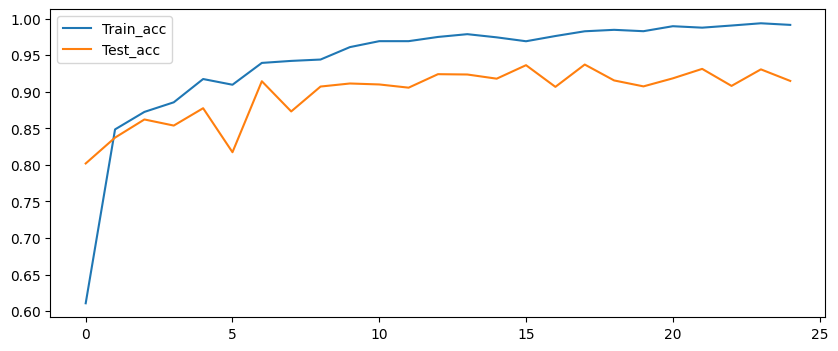

In [26]:
result[['Train_acc','Test_acc' ]].plot(figsize=(10,4))